In [ ]:
# Predict volume of receipts that will be uploaded per day for the next 4 weeks.
# Please use the provided dataset and use the uploadedTime field associated to each receipt.
#

In [243]:
import itertools
import json
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras import utils
from keras.layers import Dense, Activation, Dropout
from keras.models import Sequential
from keras.layers import LSTM
from keras.preprocessing import text
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

In [244]:
pd.options.display.max_colwidth = 10000

In [245]:
# read provided dataset
df = pd.read_csv("../receipt_data.csv")
df.head(1)

,comments,currency,lastUpdated,purchaseTime,status,uploadedTime,totalConfidence,lastOpenAt,lastVerifiedAt,taxTotal,total,deletedAt,retailerName,retailerCountry,retailerVatNumber,rawData,receiptImage
0,NaN,GBP,2019-06-15 17:00:57,2019-06-14 18:20:00,REVIEWED,2019-06-14 22:11:40,0.7,NaN,2019-06-15 17:00:57,NaN,NaN,NaN,Selfridges,GB,NaN,"{""message"":""SUCCESS: Result available"",""status"":""done"",""status_code"":3,""token"":null,""success"":true,""code"":202,""duplicate"":false,""duplicateToken"":null,""result"":{""establishment"":""Selfridges"",""validatedEstablishment"":false,""date"":""2019-06-14 18:20:00"",""total"":30.000,""url"":""www.selfridges.com"",""phoneNumber"":""8569 4004156"",""paymentMethod"":""VISA"",""address"":""400 Oxford Street London W1A 1AB"",""validatedTotal"":false,""subTotal"":30.000,""validatedSubTotal"":true,""cash"":""0.000"",""change"":""0.000"",""tax"":0.000,""discount"":0.000,""subTotalConfidence"":0.99,""totalConfidence"":0.7,""cashConfidence"":0.0,""changeConfidence"":0.0,""roundingConfidence"":0.0,""otherData"":[],""lineItems"":[{""qty"":0,""desc"":""FULTON BROLLYMA41568569 400415685692"",""unit"":"""",""price"":0.000,""descClean"":""You 193 were served by : Ines FULTON BROLLYMA 400415685692"",""lineTotal"":18.000,""productCode"":""41568569""},{""qty"":0,""desc"":""JJ DOT HYDR - TRA 82401412"",""unit"":"""",""price"":0.000,""descClean"":""JJ DOT HYDR - TRA"",""lineTotal"":12.000,""productCode"":""82401412""}],""summaryItems"":[{""qty"":2,""desc"":""Total 2 Items"",""unit"":"""",""price"":0.000,""descClean"":""Total Items"",""lineTotal"":30.000,""productCode"":""""},{""qty"":0,""desc"":""Visa"",""unit"":"""",""price"":0.000,""descClean"":""Visa"",""lineTotal"":30.000,""productCode"":""""},{""qty"":14,""desc"":""009999 Date 14 / 06 / 19"",""unit"":"""",""price"":0.000,""descClean"":""Date / 06 / 19"",""lineTotal"":18.200,""productCode"":""009999""}]}}",https://s3-eu-west-1.amazonaws.com/wevat-receipts/5955cc32-894b-4dbd-8c1f-f54fbd95d8e8


In [246]:
df['uploadedTime'].head(5)

0    2019-06-14 22:11:40
1    2019-06-19 20:01:34
2    2019-06-18 17:52:03
3    2019-06-24 12:42:05
4    2019-06-16 15:25:05
Name: uploadedTime, dtype: object

In [247]:
empty_dates = df[df.uploadedTime.apply(lambda x: not isinstance(x, str))]
empty_dates

,comments,currency,lastUpdated,purchaseTime,status,uploadedTime,totalConfidence,lastOpenAt,lastVerifiedAt,taxTotal,total,deletedAt,retailerName,retailerCountry,retailerVatNumber,rawData,receiptImage


In [248]:
# transform uploadedTime to datetime and sort
df['uploadedTime'] = pd.to_datetime(df.uploadedTime)
df.sort_values('uploadedTime')

,comments,currency,lastUpdated,purchaseTime,status,uploadedTime,totalConfidence,lastOpenAt,lastVerifiedAt,taxTotal,total,deletedAt,retailerName,retailerCountry,retailerVatNumber,rawData,receiptImage
5420,NaN,GBP,2019-04-17 09:57:51,2019-04-17 09:12:00,REVIEWED,2019-04-17 09:10:37,0.80,NaN,NaN,NaN,NaN,NaN,Boots,GB,NaN,"{""message"":""SUCCESS: Result available"",""status"":""done"",""status_code"":3,""token"":null,""success"":true,""code"":202,""duplicate"":false,""duplicateToken"":null,""result"":{""establishment"":""Lenongestoomos 18 ron agrisloxo"",""validatedEstablishment"":false,""date"":""2019-04-17 09:12:00"",""total"":2.190,""url"":"""",""phoneNumber"":""194 3487 2062"",""paymentMethod"":""VISA"",""address"":"""",""validatedTotal"":false,""subTotal"":0.000,""validatedSubTotal"":false,""cash"":""0.000"",""change"":""0.000"",""tax"":0.000,""discount"":0.000,""subTotalConfidence"":0.0,""totalConfidence"":0.8,""cashConfidence"":0.0,""changeConfidence"":0.0,""roundingConfidence"":0.0,""otherData"":[""Lenongestoomos 18 ron agrisloxo"",""1990 The own"",""e"",""10.16 ocort"",""Coralbam berujen"",""Boots UK Limited the son obert"",""MANCHESTER T1 LANDSIDE - 2062 ore"",""(0161) 4372099 Bobbs bestaan"",""17/04/2019"",""€2.19"",""194 3487 2062 133"",""""],""lineItems"":[{""qty"":17,""desc"":""17 / 04 / 2019"",""unit"":"""",""price"":0.000,""descClean"":""ore ( 0161 ) Bobbs bestaan / 04 / 2019"",""lineTotal"":9.120,""productCode"":""4372099""},{""qty"":12,""desc"":""Bp Wound Cins Wps"",""unit"":"""",""price"":0.000,""descClean"":""Served by : Connor : espoocarr.M TAV bere £ Bp Wound Cins Wps"",""lineTotal"":2.190,""productCode"":""""}],""summaryItems"":[{""qty"":0,""desc"":""TOTAL TO PAY"",""unit"":"""",""price"":0.000,""descClean"":""TOTAL TO PAY"",""lineTotal"":2.190,""productCode"":""""}]}}",https://s3-eu-west-1.amazonaws.com/wevat-receipts/c300f1fe-b2b2-4e53-986d-1f2557626793
6784,NaN,GBP,2019-04-17 11:37:56,2019-04-12 13:42:00,REVIEWED,2019-04-17 11:37:23,0.99,NaN,NaN,NaN,NaN,NaN,Boots,GB,NaN,"{""message"":""SUCCESS: Result available"",""status"":""done"",""status_code"":3,""token"":null,""success"":true,""code"":202,""duplicate"":false,""duplicateToken"":null,""result"":{""establishment"":""Boots UK Limited"",""validatedEstablishment"":false,""date"":""2019-12-04 00:00:00"",""total"":6.000,""url"":"""",""phoneNumber"":"""",""paymentMethod"":"""",""address"":"""",""validatedTotal"":false,""subTotal"":0.000,""validatedSubTotal"":false,""cash"":""0.000"",""change"":""0.000"",""tax"":0.000,""discount"":0.000,""subTotalConfidence"":0.0,""totalConfidence"":0.99,""cashConfidence"":0.0,""changeConfidence"":0.0,""roundingConfidence"":0.0,""otherData"":[""Boots UK Limited"",""lets ieel good"",""ADVANTAGE CARD STATENENT"",""Points Received"",""Points to Spend in Store"",""5704"",""""],""lineItems"":[],""summaryItems"":[{""qty"":0,""desc"":""TOTAL TO PAY"",""unit"":"""",""price"":0.000,""descClean"":""TOTAL TO PAY"",""lineTotal"":6.000,""productCode"":""""}]}}",https://s3-eu-west-1.amazonaws.com/wevat-receipts/2f5b7edb-59bb-4224-8cd7-01f07ac4662e
1776,NaN,GBP,2019-04-17 13:32:52,2019-08-04 17:36:00,REVIEWED,2019-04-17 13:28:39,0.70,NaN,NaN,NaN,NaN,NaN,Debenhams,GB,NaN,"{""message"":""SUCCESS: Result available"",""status"":""done"",""status_code"":3,""token"":null,""success"":true,""code"":202,""duplicate"":false,""duplicateToken"":null,""result"":{""establishment"":""DEBENHAMS"",""validatedEstablishment"":false,""date"":""2019-04-08 17:36:00"",""total"":156.000,""url"":""howdidwedotoday.debenhams.com"",""phoneNumber"":""0344 561 6161"",""paymentMethod"":""Mastercard"",""address"":"", TEL NO 0344 561 6161"",""validatedTotal"":false,""subTotal"":156.000,""validatedSubTotal"":true,""cash"":""0.000"",""change"":""0.000"",""tax"":0.000,""discount"":0.000,""subTotalConfidence"":0.99,""totalConfidence"":0.7,""cashConfidence"":0.0,""changeConfidence"":0.0,""roundingConfidence"":0.0,""otherData"":[""THANK YOU FOR SHOPPING AT"",""DEBENHAMS"",""BIRMI

In [249]:
# floor uploadedTime to day and aggregate count
daily_receipts = (df.uploadedTime
       .dt.floor('d')
       .value_counts()
       .rename_axis('uploadedDate')
       .reset_index(name='counts'))
daily_receipts.head(5)

,uploadedDate,counts
0,2019-06-29,278
1,2019-06-30,274
2,2019-06-22,243
3,2019-06-21,231
4,2019-06-26,229


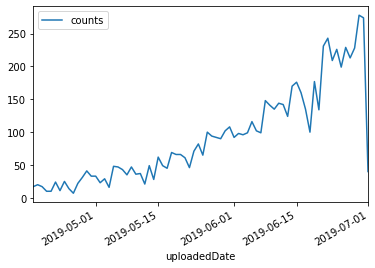

In [250]:
daily_receipts.plot(x='uploadedDate', y='counts', kind="line")
plt.show()

In [270]:
daily_receipts.counts = daily_receipts.counts.astype('float32')
daily_receipts = daily_receipts.sort_values(by=['counts'])
daily_receipts.head(2)

,uploadedDate,counts
75,2019-04-26,7.0
74,2019-04-21,10.0


In [271]:
dataset = daily_receipts.values

In [281]:
scaler = MinMaxScaler(feature_range = (0, 1))
dataset = scaler.fit_transform(daily_receipts.filter(['counts']))

array([[0.        ],
       [0.01107011],
       [0.01107011],
       [0.01476015],
       [0.02583026],
       [0.03321033],
       [0.03690037],
       [0.03690037],
       [0.04797048],
       [0.05166052],
       [0.05535055],
       [0.05904059],
       [0.06273063],
       [0.06642066],
       [0.07749077],
       [0.08118081],
       [0.08856089],
       [0.09594096],
       [0.09594096],
       [0.10332103],
       [0.10701107],
       [0.11070111],
       [0.12177122],
       [0.12546125],
       [0.13284133],
       [0.1402214 ],
       [0.14391144],
       [0.14760148],
       [0.14760148],
       [0.15129151],
       [0.15498155],
       [0.15498155],
       [0.19926199],
       [0.20295203],
       [0.21402214],
       [0.21771218],
       [0.21771218],
       [0.22878229],
       [0.23616236],
       [0.27675277],
       [0.30627306],
       [0.31365314],
       [0.31365314],
       [0.32103321],
       [0.32841328],
       [0.33579336],
       [0.33948339],
       [0.339

In [282]:
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

50 26


In [283]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [284]:
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [285]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [286]:
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
 - 3s - loss: 0.0295
Epoch 2/100
 - 0s - loss: 0.0181
Epoch 3/100
 - 0s - loss: 0.0131
Epoch 4/100
 - 0s - loss: 0.0112
Epoch 5/100
 - 0s - loss: 0.0105
Epoch 6/100
 - 0s - loss: 0.0101
Epoch 7/100
 - 0s - loss: 0.0099
Epoch 8/100
 - 0s - loss: 0.0095
Epoch 9/100
 - 0s - loss: 0.0093
Epoch 10/100
 - 0s - loss: 0.0090
Epoch 11/100
 - 0s - loss: 0.0087
Epoch 12/100
 - 0s - loss: 0.0084
Epoch 13/100
 - 0s - loss: 0.0080
Epoch 14/100
 - 0s - loss: 0.0076
Epoch 15/100
 - 0s - loss: 0.0073
Epoch 16/100
 - 0s - loss: 0.0071
Epoch 17/100
 - 0s - loss: 0.0065
Epoch 18/100
 - 0s - loss: 0.0061
Epoch 19/100
 - 0s - loss: 0.0056
Epoch 20/100
 - 0s - loss: 0.0051
Epoch 21/100
 - 0s - loss: 0.0045
Epoch 22/100
 - 0s - loss: 0.0039
Epoch 23/100
 - 0s - loss: 0.0034
Epoch 24/100
 - 0s - loss: 0.0029
Epoch 25/100
 - 0s - loss: 0.0023
Epoch 26/100
 - 0s - loss: 0.0019
Epoch 27/100
 - 0s - loss: 0.0014
Epoch 28/100
 - 0s - loss: 0.0011
Epoch 29/100
 - 0s - loss: 8.6610e-04
Epoch 30/100
 - 0s 

In [287]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))

print('Train Score: %.2f RMSE' % (trainScore))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 2.56 RMSE
Test Score: 16.35 RMSE


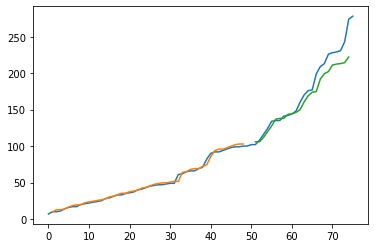

In [288]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)

plt.show()